In [6]:
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
%matplotlib notebook

## Reading Data from Estimator Logs

Replace this part with whatever logging scheme we're using

In [76]:
# read the file
fname = "log3_continuous.txt"
f = open(fname)
lines = f.readlines()
f.close()

In [78]:
class LoggedInfo:
    def __init__(self, states, foot_locs, inputs, ones, X_s, y_s):
        self.states = states
        self.foot_locs = foot_locs
        self.inputs = inputs
        self.ones = ones
        self.X_s = X_s
        self.y_s = y_s
        
# get the A, B, and b matrices
def get_matrix(lines, cur_pointer):
    tmp = []
    while cur_pointer < len(lines) and lines[cur_pointer][0] != "#":
        tmp.append(lines[cur_pointer])
        cur_pointer += 1
    
    matrix = []
    for line in tmp:
        l_split = line.strip("\n").split(" ")
        matrix.append([float(s) for s in l_split if s != ""])
    return matrix, cur_pointer+1

## Assumes that you start from the first line of 
def get_logged_states_and_matrices(lines, cur_pointer):
    p = cur_pointer
    states = []
    foot_locs = []
    inputs = []
    ones = []  # this is just for convenience
    X_s = []
    y_s = []
    while p < len(lines):
        # get state shit
        vec_row, p = get_matrix(lines, p)
        vec_row = (np.array(vec_row).T)[0]
        states.append(vec_row[0:12])
        foot_locs.append(vec_row[12:15])
        # change to 20 for pitch torque
        inputs.append(vec_row[15:20])
        ones.append(vec_row[20:])
        
        # get X_
        X_, p = get_matrix(lines, p)
        X_s.append(np.array(X_))

        # get y_
        y_, p = get_matrix(lines, p)
        y_s.append(np.array(y_))

        if p + 100 + 100 + 31 >= len(lines):
            break
    return LoggedInfo(states, foot_locs, inputs, ones, X_s, y_s)

In [79]:
A, cp = get_matrix(lines, 1)
B, cp = get_matrix(lines, cp)
b, cp = get_matrix(lines, cp)
logged_stuff = get_logged_states_and_matrices(lines, cp)

In [80]:
states = logged_stuff.states
inputs = logged_stuff.inputs
foot_locs = logged_stuff.foot_locs
ones = logged_stuff.ones
X_s = logged_stuff.X_s
y_s = logged_stuff.y_s
A = np.array(A)
B = np.array(B)
b = np.array(b).squeeze()

## Function Definitions for Least Squares Estimator

In [ ]:
# container class for dynamics
class LinearDynamics:
    def __init__(self, A, B, b):
        self.A = A
        self.B = B
        self.b = b
        
    def forward(self, x, u):
        return self.A@x + self.B@u + self.b
    
"""
Estimates the residual dynamics in a dense way
- x: array(T, nx_ + 3) the single rigid body state including the stance foot location 
- u: array(T, nu_) the contact forces at time T
- xdot: array(T, nx_) the state derivatives
- stance_mode array(T, 1): which stance mode we are in
- dt (double): the time between states x
"""
def dense_residual_estimator(x, u, xdot, stance_modes, dynamics, dt = 1/2000.0):
    x = np.array(x)
    u = np.array(u)
    xdot = np.array(xdot)
    
    assert x.shape[0] == u.shape[0] and x.shape[0] == xdot.shape[0], "data matrices must be same time-length"

    
    T = x.shape[0]
    X = np.zeros((T, x.shape[1] + u.shape[1] + 1))
    y = np.zeros((T, xdot.shape[1]))
    
    for t in range(T):
        state = x[t]
        input = u[t]
        deriv_nom = dynamics[stance_modes[t]].forward(state, input)
        X[t] = np.concatenate([state, input, np.ones(1)])
        y[t] = xdot[t] - deriv_nom
    
    X_c = X[:-1,:]
    y_c = y[:-1,:]
    soln = (np.linalg.pinv(X_c.T @ X_c + 0.1 * np.eye(X_c.shape[1])) @ X_c.T @ y_c).T
    A_hat = soln[:,:x.shape[1]]
    B_hat = soln[:,x.shape[1]:x.shape[1] + u.shape[1]]
    b_hat = soln[:,-1]
    return LinearDynamics(A_hat, B_hat, b_hat)


"""
Estimates the residual dynamics in a sparse way.
Requires the states to be ordered in a particular way.
- x: array(T, 15) the single rigid body state including the stance foot location 
- u: array(T, 5) the contact forces at time T
- xdot: array(T, 12) the state derivatives
- stance_mode array(T, 1): which stance mode we are in
- dt (double): the time between states x
"""
def sparse_residual_estimator(x, u, xdot, stance_modes, dynamics, dt = 1/2000.0):
    x = np.array(x)
    u = np.array(u)
    xdot = np.array(xdot)
    assert x.shape[1] == 15
    assert u.shape[1] == 5
    assert xdot.shape[1] == 12
    assert x.shape[0] == u.shape[0] and x.shape[0] == xdot.shape[0]
    
    T = x.shape[0]
    X1 = np.zeros((T, 3))
    X2 = np.zeros((T, 3))
    X3 = np.zeros((T, 4))
    X4 = np.zeros((T, 12))
    
    y1 = np.zeros((T, 3))
    y2 = np.zeros((T, 3))
    y3 = np.zeros((T, 3))
    y4 = np.zeros((T, 3))
    for t in range(T):
        state = x[t]
        input = u[t]
        deriv_nom = dynamics[stance_modes[0]].forward(state, input)
        y1[t] = xdot[t][0:3] - deriv_nom[0:3]
        y2[t] = xdot[t][3:6] - deriv_nom[3:6]
        y3[t] = xdot[t][6:9] - deriv_nom[6:9]
        y4[t] = xdot[t][9:12] - deriv_nom[9:12]
        
        X1[t] = state[6:9]
        X2[t] = state[9:12]
        X3[t] = np.concatenate([input[0:3], np.ones(1)])
        X4[t] = np.concatenate([state[0:3], state[12:15], input[0:5], np.ones(1)])
        
    X1_c = X1[:-1,:]
    X2_c = X2[:-1,:]
    X3_c = X3[:-1,:]
    X4_c = X4[:-1,:]
    
    y1_c = y1[:-1,:]
    y2_c = y2[:-1,:]
    y3_c = y3[:-1,:]
    y4_c = y4[:-1,:]
    
    soln1 = (np.linalg.pinv(X1_c.T @ X1_c) @ X1_c.T @ y1_c).T
    soln2 = (np.linalg.pinv(X2_c.T @ X2_c) @ X2_c.T @ y2_c).T
    soln3 = (np.linalg.pinv(X3_c.T @ X3_c) @ X3_c.T @ y3_c).T
    soln4 = (np.linalg.pinv(X4_c.T @ X4_c) @ X4_c.T @ y4_c).T
    
    A = np.zeros((12, 15))
    B = np.zeros((12, 5))
    b = np.zeros(12)
    
    A[0:3,6:9] = soln1
    A[3:6, 9:12] = soln2
    A[9:12, 0:3] = soln4[0:3, 0:3]
    A[9:12, 12:15] = soln4[0:3, 3:6]
    
    B[6:9, 0:3] = soln3[0:3, 0:3]
    B[9:12, 0:3] = soln4[0:3, 6:9]
    B[9:12, 3:4] = soln4[0:3, 9:10]
    B[9:12, 4:5] = soln4[0:3, 10:11]
    
    b[6:9] = soln3[0:3, 3:4].squeeze()
    b[9:12] = soln4[0:3, 11:12].squeeze()
    
    return LinearDynamics(A, B, b)


"""
Evaluate the residual dynamics on a test set
returns:
- array of the norm of the error at each time step
- residual x_dots
- nominal x_dots
"""
def evaluate_residual_estimator(x, u, xdot, stance_modes, nominal_dynamics, residual_dynamics):
    x = np.array(x)
    u = np.array(u)
    xdot = np.array(xdot)
    
    if x.shape[0] != u.shape[0] or x.shape[0] != xdot.shape[0]:
        print("Error: all data must have the same first dimension")
    T = x.shape[0]
    errors_res = np.zeros(T)
    errors_nom = np.zeros(T)
    residual_derivs = np.zeros((T, xdot.shape[1]))
    nominal_derivs = np.zeros((T, xdot.shape[1]))
    for t in range(T):
        nominal_deriv = nominal_dynamics[stance_modes[t]].forward(x[t], u[t])
        residual_deriv = residual_dynamics.forward(x[t], u[t])
        errors_res[t] = np.linalg.norm(xdot[t] - (nominal_deriv + residual_deriv))
        errors_nom[t] = np.linalg.norm(xdot[t] - nominal_deriv)
        residual_derivs[t] = residual_deriv
        nominal_derivs[t] = nominal_deriv
    return errors_res, errors_nom, residual_derivs, nominal_derivs

## Using Least Squares w/ Logged Data

Getting the residual dynamics

In [141]:
T = 200

dynamics = [LinearDynamics(A, B, b)] # TODO: add the other stance mode to this 
modes = [0 for i in range(T)]

derivs = [(states[t+1] - states[t]) * 2000 for t in range(T)]
states_and_steps = np.hstack([states, foot_locs])
residual_dynamics = sparse_residual_estimator(states_and_steps[:T], inputs[:T], derivs, modes, dynamics)

Evaluating Residuals on data

In [142]:
T = 200
modes = [0 for i in range(T)]
derivs = [(states[t+1] - states[t]) * 2000 for t in range(T)]
states_and_steps = np.hstack([states, foot_locs])

errors_res, errors_nom, ress, noms = evaluate_residual_estimator(states_and_steps[:T], inputs[:T], 
                                                 derivs, modes, dynamics, residual_dynamics)

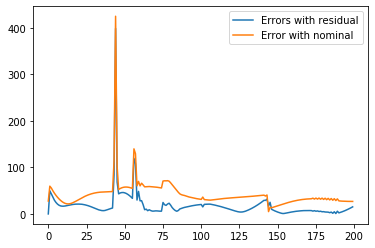

In [143]:
fig = plt.figure()
ax = fig.gca()
ax.plot(errors_res)
ax.plot(errors_nom)
ax.legend(["Errors with residual", "Error with nominal"])